In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pandas.plotting import scatter_matrix 
from sklearn.metrics import confusion_matrix




In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


## load tested data


In [5]:
# Load the data from the .csv file
data = pd.read_csv('cleaned_descriptor_data',index_col=0)

# Scale the data with a standard scaling
scaling=MinMaxScaler()
scaling.fit(data)
scaled_data=scaling.transform(data)
df_data = pd.DataFrame(scaled_data, columns=data.columns,index=data.index)

# Choose the kinase of which you want to predict the inhibition
#selected_kinase = 'ERK2_inhibition'
selected_kinase = 'PKM2_inhibition'     # Or 'ERK2_inhibition'

# Define train and test data
X = df_data.drop(columns=['ERK2_inhibition','PKM2_inhibition']).copy()
y = data[selected_kinase].copy()


In [6]:
X_fingerprints=pd.read_csv('fingerprint_data',index_col=0)

## Load untested data

In [7]:
untested_molecules=pd.read_csv('cleaned_descriptor_data_untested',index_col=0)
untested_molecules.head()
X_untested=untested_molecules.drop(columns=['ERK2_inhibition','PKM2_inhibition']).copy()
y_untested=untested_molecules[selected_kinase].copy()


In [8]:
X_untested_fingerprints=pd.read_csv('fingerprint_data_untested',index_col=0)

## Recursive Feature Exclusion

In [13]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=50)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print(selected_features)

Index(['MaxAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MinPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0n', 'Chi3v', 'HallKierAlpha',
       'Ipc', 'Kappa1', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA5', 'PEOE_VSA7',
       'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9',
       'SlogP_VSA2', 'SlogP_VSA5', 'SlogP_VSA6', 'TPSA', 'EState_VSA3',
       'EState_VSA5', 'EState_VSA6', 'VSA_EState1', 'VSA_EState2',
       'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState9',
       'NumAromaticHeterocycles', 'MolLogP', 'fr_Ar_N', 'fr_sulfonamd'],
      dtype='object')


In [14]:
X_cleaned=X[selected_features]
X_untested_cleaned=X_untested[selected_features]

# Random forests

## Random forest with descriptors evaluation

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, stratify=y)

# Bereken de ratio tussen 0 and 1 
ratio_train = y_train.value_counts(normalize=True)

# Bereken de ratio tussen 0 and 1
ratio_test = y_test.value_counts(normalize=True)

print("Ratio of 0 and 1 inhibitors in the training set:")
print(ratio_train)
print("\nRatio of 0 and 1 inhibitors in the testing set:")
print(ratio_test)

# Weigth
# class_weights = {0: 1, 1: 1}  # Aanpassen op weigth distribution
rf_descriptors = RandomForestClassifier(n_estimators=1100)#, class_weight=class_weights)
rf_descriptors.fit(X_train, y_train)
y_pred = rf_descriptors.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)




Ratio of 0 and 1 inhibitors in the training set:
0    0.975336
1    0.024664
Name: PKM2_inhibition, dtype: float64

Ratio of 0 and 1 inhibitors in the testing set:
0    0.973214
1    0.026786
Name: PKM2_inhibition, dtype: float64
[[217   1]
 [  6   0]]


## Test met SMOTE

Ratio of 0 and 1 inhibitors in the balanced training set:
0    0.5
1    0.5
Name: PKM2_inhibition, dtype: float64

Ratio of 0 and 1 inhibitors in the testing set:
0    0.973214
1    0.026786
Name: PKM2_inhibition, dtype: float64
Confusion Matrix:
[[215   3]
 [  6   0]]


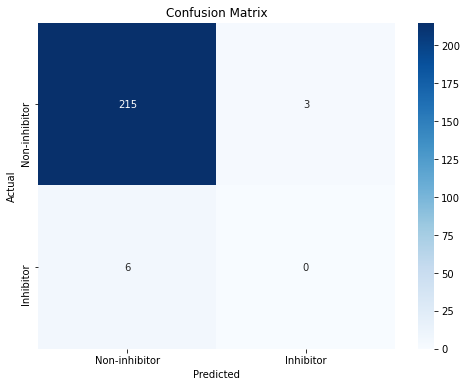

In [16]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Calculate the ratio between 0 and 1 in the balanced training set and the test set
ratio_train_balanced = y_train_balanced.value_counts(normalize=True)
ratio_test = y_test.value_counts(normalize=True)

print("Ratio of 0 and 1 inhibitors in the balanced training set:")
print(ratio_train_balanced)
print("\nRatio of 0 and 1 inhibitors in the testing set:")
print(ratio_test)

# Train the Random Forest model with the balanced training set
rf_descriptors = RandomForestClassifier(n_estimators=1100, random_state=42)
rf_descriptors.fit(X_train_balanced, y_train_balanced)
y_pred = rf_descriptors.predict(X_test)

# Evaluate the model using a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)


## Random forest with fingerprints evaluation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_fingerprints, y, test_size=0.2, stratify=y)

# Bereken de ratio tussen 0 and 1 
ratio_train = y_train.value_counts(normalize=True)

# Bereken de ratio tussen 0 and 1
ratio_test = y_test.value_counts(normalize=True)

print("Ratio of 0 and 1 inhibitors in the training set:")
print(ratio_train)
print("\nRatio of 0 and 1 inhibitors in the testing set:")
print(ratio_test)

# Weigth
# class_weights = {0: 1, 1: 1}  # Aanpassen op weigth distribution
rf_fingerprints= RandomForestClassifier(n_estimators=1100)#, class_weight=class_weights)
rf_fingerprints.fit(X_train, y_train)
y_pred = rf_fingerprints.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)


Ratio of 0 and 1 inhibitors in the training set:
0    0.975336
1    0.024664
Name: PKM2_inhibition, dtype: float64

Ratio of 0 and 1 inhibitors in the testing set:
0    0.973214
1    0.026786
Name: PKM2_inhibition, dtype: float64
[[218   0]
 [  6   0]]


## Random forest with descriptors on actual data

In [10]:
rf_descriptors = RandomForestClassifier(n_estimators=1100)#, class_weight=class_weights)
rf_descriptors.fit(X_cleaned, y)
y_pred_descriptor = rf_descriptors.predict(X_untested_cleaned)
df_y_pred_descriptor=pd.DataFrame(y_pred_descriptor,index=X.index)


## Random forest with fingerprints on actual data

In [11]:
rf_fingerprints = RandomForestClassifier(n_estimators=1100)#, class_weight=class_weights)
rf_fingerprints.fit(X_fingerprints, y)
y_pred_fingerprint = rf_descriptors.predict(X_untested_cleaned)
df_y_pred_fingerprint=pd.DataFrame(y_pred_descriptor,index=X.index)

## Intersect

In [12]:
intersect=X[(df_y_pred_descriptor[0]==1)&(df_y_pred_fingerprint[0]==1)].index
intersect

Index(['C=C(C)c1nc(N)nc(N)n1', 'C=CCNC(=O)CCCC(=O)NCC=C',
       'C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21', 'C=CCn1cc(Cl)c(=O)n(CC=C)c1=O',
       'CC(C)(N[O-])/C(=N/O)c1cccs1', 'CC(C)C(=O)Nc1cc(=O)nc2nc[nH]n12',
       'CC(C)[NH+](Cc1nc2ccccc2[nH]1)C(C)C', 'CC(C)c1ccc(NC(=O)c2cccnc2)cc1',
       'CCC(CC)C(=O)NCc1ccccc1OC', 'CCN(CC)S(=O)(=O)c1cccc2nonc12',
       ...
       'COc1ccc(OC)c(Nc2cc(-c3ccccc3)nc(N)n2)c1',
       'Cc1nnc(SCCC(=O)Nc2nc(-c3ccccc3)ns2)s1',
       'Cc1noc(C)c1CSc1nc2[nH]ncc2c(=O)n1-c1ccccc1',
       'O=C(COc1ccc(Cl)cc1)Nc1nc(-c2cccs2)cs1',
       'O=C1OCC2=C1[C@@H](c1ccc3c(c1)OCO3)Sc1ccccc1N2',
       'O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1',
       'O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1',
       'Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12',
       'c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1',
       'c1ccc(C2=Nn3c(nnc3-c3cc(-c4ccccc4)n[nH]3)SC2)cc1'],
      dtype='object', name='SMILES', length=669)